# Search Word Suggestions

Eddy Shyu


Given a search term, suggest other search terms.

### Overview of approach

- I assume that search terms assigned to the same shared gif are related.  I gather all search terms associated with the same shared gif and create inputs and outputs.
- An input is a search term, and the output is the list of all the search terms related to it.  So, for instance, the model takes as input the search 'puppy', and targets a list of similar terms ['cute puppy', 'puppy dog', 'pup', 'doggy'].  I do this by one-hot encoding the search terms and then adding all the one-hot codes into one vector.  
- I pass this data through a neural network so that it can learn to predict similar search terms by training on all of the groups of similar terms.


### sample predictions

- The predictions appear to do better for search terms that tend to occur more frequently.  Here are a few that turned out better.  I passed data through 8 times to get these predictions; normally I'd need to cycle through the data 10 to 100 times depending on the project:

Trial 4b, 1 hidden layer, 8 epochs

search term: excited || suggestions: yas, tgif, yes, yummy, vacation, yay, dan, excited, wonder woman, metal

search term: i love you || suggestions: i miss you more, miss ypu, babys, i missed you, miss, love you, thinking of you, i miss you too, i need you, i miss you

search term: yes || suggestions: of course, oh yeah, tehehe, jerking off, godamn right, ok, yes, excited, yea, for sure

search term: what ever || suggestions: thats more like it, yes masta, thinking, yes sjr, bye, yes sit, you never know, whatevee, class, delicious

search term: face palm || suggestions: hands, crazy, ouch, fairly odd parents, whining, delivery, michael jordan, rubbing, food delivery, prey

search term: party || suggestions: miss congeniality kiss me, protozoa, swag, miss congenialitt, birthday girl, girls weekend, birthday, miss congeniality, zenon, birthday party

search term: blink || suggestions: shocked white man, blinking eyes, man blinking, blinking, white man blinking, blink meme, white guy shocked, eye meme, blinks eyes, white guy blinking

search term: wink || suggestions: i'm sure, jim halpert, beyonce, running naked, wink wink, naked run, don't do it, the beach, tongue wink, i dont know about that

search term: puppy || suggestions: skeep, good nite, im going to sleep, going to bed, sleep tight, gnite, see you tomorroe, have a good night, goof night, tomorrow

search term: kitten || suggestions: cat mittens, butt massage, kitten mitten, kitten mittens, you sure, mitten, mittens, are you, dory, keep telling yourself that

search term: cute || suggestions: shane, aww, puppies, cheers tv, blood hounds dog, smoothie, cute puppies, kristen, dead chicken, tweety

search term: funny || suggestions: undertale, dancing, midget, caddyshack, fat person, super fat, fat kid, fat asian, @rarijack, sans

search term: obama || suggestions: you good, we don't need you, aristocats, let me live, i aint a snitch, boy bye, i aint no bitch, black tie, cleveland, south side

search term: trump || suggestions: hard hat, @twelch78, donald trump, wrong trunp, trump wronf, donald wrong, wrong trump, shorty, wrong donald trump, trump wrong

search term: taylor swift || suggestions: boy stop, sunday, wink, wizard of oz, rest in peace, wave, taylor, blank space, taylor swift 22, swift

search term: beyonce || suggestions: good morning beyoncé, brush off shoulders, boss lady, emperors new groove, go fuck yourself, beyonce boss, boss, shoulders, stuck, beyonce good morning

### Optimizing the model
- For the search terms associated with the same gif, I already counted how often each search term occurs.  I can modify the inputs to put more emphasis on the more frequent search terms.  For instance, I can add more copies of the more frequent search terms into the training data.

- I should also find an alternative to one-hot encoding search terms, because the neural net gets too big at the output layer, making it hard to train.  
- One thing I can try is to first train the embedding layer and then use it as a word vector.  Then the output layer can try to predict the embedding layer (which is 300 units instead of 80,000).  Then I can use cosine distance (dot product of two vectors) to choose the term most similar to the output vector.  
- In place of the trained word vector, I can use existing word2vec and GloVe vectors and find matching words within the search terms to choose a word vector for each search term.

### Alternative Ideas

- I can skip the neural network and focus on aggregating the groups of similar search terms.  For instance, more than one gif likely has the same search term assigned to it, so I could merge the groups of similar terms when I find that they both include the same text.
- Use a nearest neighbors approach:  I can assign a word vector to each search term by finding words within the search that exist in word2vec or GLoVe.  Then use k-nearest neighbors to find search terms that have the same or similar word vector.
- Use a collaborative filtering approach: Put the gifs and search term counts in a co-occurrence matrix.  For a search, find associated gifs, and from the gifs, find associated search terms.


In [2]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import numpy as np
import tensorflow as tf
#import utils
from datetime import datetime
import pickle
from collections import OrderedDict
import unittest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from __future__ import print_function

%matplotlib inline

In [4]:
def query(q):
    """
    Query and fetch data. Rollback if error
    """
    try:
        cur.execute(q)
        return cur.fetchall()
    except psycopg2.Error as e:
        print(e.pgerror)
        print("database error occured, rollback")
        con.rollback()

#### Notes about the data

Remove the blank (if len is zero, don't count it)

Also remove if the word is 'Recents', because this is a keyword

note that riffid =0 always has viewindex = -1, so I don't think it's an actual gif.

riffid(s) are returned as strings

Some searches are identical excep that one has whitespace between words and the other has none.  I'll want to fix this in data cleaning step when I have time.  For example, if I have "face palm" and I remove whitespace and match it to a search of "facepalm", then I can take that "facepalm" search and count it towards "face palm".

In [5]:
def get_riffid(thresh=50, fast=False):
    """
    Note that 'favorites' looks like a keyword, as it doesn't fit the words that it's grouped with.
    """    
    q_str = " \
            select riffid, count(*) as n_ \
            from ios_events \
            where tags != '' \
            and riffid != 0 \
            group by riffid \
            having count(*) >= {} \
            order by n_ desc; \
            ".format(thresh)
    
    riffid = query(q_str)
    riffid_l = [row[0] for row in riffid]
    if fast:
        return riffid_l
    riffid_df = pd.DataFrame(riffid, columns=['riffid','n_'])

    
    return riffid, riffid_l, riffid_df

In [6]:
riffid, riffid_l, riffid_df = get_riffid(thresh=10)

In [7]:
riffid_df.describe()

,n_
count,163382.000000
mean,126.983682
std,686.537257
min,10.000000
25%,16.000000
50%,31.000000
75%,77.000000
max,61184.000000


In [8]:
print("There are {:,} riffids.".format(len(riffid_l)))

There are 163,382 riffids.


In [9]:
def tags_same_gif(riffid_l=['7513882','7212866'], fast=False):

    riffid_l_in = "('" + '\',\''.join(riffid_l) + "')"
    q_str = "\
        select LOWER(tags) as tags, riffid, count(*) as n_ \
        from ios_events \
        where riffid in {} \
        and LOWER(tags) not in ('','recent','recents','favorites','favorite') \
        group by LOWER(tags), riffid \
        having count(*) >= 2 \
        order by riffid, n_ desc;\
        ".format(riffid_l_in)
    #print(q_str)
    tags = query(q_str)
    if fast:
        return tags
    
    tags_df = pd.DataFrame(tags,columns=['tags', 'riffid', 'n_'])
    return tags, tags_df

In [10]:
start_t = datetime.now()
tags, tags_df = tags_same_gif(riffid_l=riffid_l)
print("runtime {}".format(datetime.now() - start_t))
data_vars = {'riffid_l':riffid_l,
             'riffid_df': riffid_df,
             'tags': tags,
             'tags_df': tags_df
            }
data_file = 'data_vars.p'
pickle.dump(data_vars,open(data_file, 'wb'), protocol=2)

runtime 0:00:08.938714


In [11]:
tags_df.describe()

,n_
count,877666.000000
mean,21.646441
std,219.341571
min,2.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,44282.000000


### Jump to here to load queried data
group by riffid, then use for loop to get groups with the same riffid.

extract the list of similar words and then turn them into input and output

In [12]:
data_file = 'data_vars.p'
data_vars = pickle.load(open(data_file, 'rb'))

In [148]:
data_vars.keys()

['riffid_df',
 'target_l',
 'tags',
 'input_l',
 'int_to_search',
 'tags_df',
 'target_int',
 'search_to_int',
 'riffid_l',
 'unique_search_s',
 'tag_group_d',
 'input_int']

In [153]:
tags_df = data_vars['tags_df']

In [154]:
tags_df.head(5)

,tags,riffid,n_
0,morning night,100769454,13
1,rooster teeth,100799838,6
2,@pattynonamee,100799838,3
3,:),100815674,11
4,:),100819670,8


In [155]:
def remove_duplicates(search_l):
    """
    example:
    ['puppy dog', 'puppydog', 'cutepuppy', 'cute puppy']
    use ordered dictionary to preserve popularity of search,
    where key is search without any whitespace, 
    value is original searches with trailing space removed.  
    Replace value if I find a string of longer length,
    indicating that it has whitespace.
    
    'puppy dog '-> add 'puppydog': 'puppy dog'
    'puppydog' -> find 'puppydog' has value 'puppy dog', which is longer than 'puppydog', don't add duplicate.
    ' cutepuppy ' -> add 'cutepuppy': 'cutepuppy', since it's new
    'cute puppy' -> replace 'cutepuppy: 'cute puppy', since string length is longer (after trimming whitespace)
    
    """
    
    unique_d = OrderedDict()
    
    for s in search_l:
        key = s.replace(' ', '')
        val = s.strip()
        if unique_d.get(key):
            if len(val) > len(unique_d[key]):
                unique_d[key] = val

        else:
            unique_d[key] = val

    unique_l = list(unique_d.values())
    return unique_l
    

In [156]:
class TestRemoveDuplicates(unittest.TestCase):
    def setUp(self):
        self.l1 = ['puppy dog ', ' puppydog ', '  cutepuppy  ', 'cute puppy']
        self.l2 = ['hereyougo', 'whatever', 'here you go ', 'hereyou go', 'what ever']
        return

    def tearDown(self):
        self.l1 = None
        self.l2 = None
        return
    
    def test1(self):
        unique_l = remove_duplicates(self.l1)
        self.assertEqual(unique_l,['puppy dog','cute puppy'])

    def test2(self):
        unique_l = remove_duplicates(self.l2)
        self.assertEqual(unique_l,['here you go','what ever'])
    
if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestRemoveDuplicates)
    unittest.TextTestRunner(verbosity=2).run(suite)

test1 (__main__.TestRemoveDuplicates) ... ok
test2 (__main__.TestRemoveDuplicates) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


In [186]:
"""
Collect a dictionary where key is the most common search term,
and value is the list of similar searches (all of them)

Here, I can work on merging duplicates.

I also want to add words to a set of unique words.

Once I have the list of similar searches, create inputs and labels.
Input is a single word, and outputs are all the other words in the similarity group.

"""
def get_groups_and_unique_searches(tags_df):
    tags_by_riffid_df = tags_df.groupby('riffid')
    
    tag_group_d = dict() 
    unique_search_s = set()
    n_vocab = 0
    for riffid, tags_df in tags_by_riffid_df:
        search_l = list(tags_df['tags'])
        #most popular term is at index 0
        unique_search_l = remove_duplicates(search_l)
        #we need the list to have at least 2 similar searches
        if len(unique_search_l) > 1:
            n_vocab += len(unique_search_l)
            unique_search_s.update(unique_search_l)
            tag_group_d[unique_search_l[0]] = unique_search_l
            
    print("n_vocab (includes duplicates) {:,}".format(n_vocab))
    return tag_group_d, unique_search_s

In [187]:
tag_group_d, unique_search_s = get_groups_and_unique_searches(tags_df)

n_vocab 798,314


In [188]:
#verify that keywords like recent and favorites not in the tags
if tag_group_d.get('favorites'):
    print("should not be here")
if tag_group_d.get('favorite'):
    print("should not be here")
if tag_group_d.get('recent'):
    print("should not be here")
if tag_group_d.get('recents'):
    print("should not be here")

In [189]:
print("There are {:,} groups of similar searches and {:,} unique searches".format(len(tag_group_d),len(unique_search_s)))

There are 32,428 groups of similar searches and 181,151 unique searches


In [190]:
data_vars['tag_group_d'] = tag_group_d
data_vars['unique_search_s'] = unique_search_s

data_file = 'data_vars.p'
pickle.dump(data_vars,open(data_file, 'wb'), protocol=2)

### Create input and targets

input is a single search term, target a set of similar search terms.

I will one-hot encode the targets and combine the one-hot encodings with a sum. When the neural net makes predictions, it will try to predict all similar words.  If I were to only provide one target word at a time, then the net will learn to decrease the predictions for correct words when the training data is only providing one word for it to match.

Later, I may also have to handle when two different groups of words have overlapping search terms.  I'll need to merge these groups.

In [25]:
data_file = 'data_vars.p'
data_vars = pickle.load(open(data_file, 'rb'))

tag_group_d = data_vars['tag_group_d']

In [191]:
# see the distribution of the length of each group of similar words
group_len = [len(g) for g in tag_group_d.values()]
group_len_df = pd.DataFrame(group_len)
group_len_df.describe()

,0
count,32428.000000
mean,4.216387
std,3.666657
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,108.000000


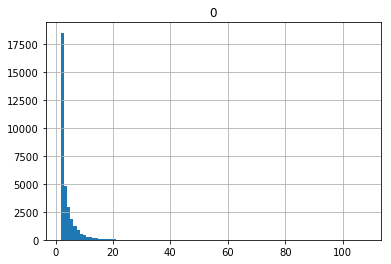

In [27]:
group_len_df.hist(bins=100);

In [192]:
def get_input_target(group, index=0):
    
    if len(group) <=1:
        return None, None
    
    if index < 0 or index > len(group)-1:
        return None, None
    
    input_ = group[index]
    target = group[:index] + group[index+1:]
    
    return input_, target

In [193]:

class TestGetInputTarget(unittest.TestCase):
    def setUp(self):
        self.l0 = ['zero']
        self.l1 = ['zero','one']
        self.l2 = ['zero','one','two','three','four']
        self.l3 = ['zero','one','two','three','four','five','six','seven','eight']
        return

    def tearDown(self):
        self.l0 = None
        self.l1 = None
        self.l2 = None
        self.l3 = None
        return
    
    def test0(self):
        input_, target = get_input_target(self.l0,0)
        self.assertIsNone(input_)
        self.assertIsNone(target)
        
    def test1(self):
        input_, target = get_input_target(self.l1,2)
        self.assertIsNone(input_)
        self.assertIsNone(target)
        
        input_, target = get_input_target(self.l1,0)
        self.assertEqual(input_,'zero')
        self.assertEqual(target,['one'])
        
    def test2(self):
        input_, target = get_input_target(self.l2,1)
        self.assertEqual(input_,'one')
        self.assertEqual(target,['zero','two','three','four'])
        
    def test3(self):
        input_, target = get_input_target(self.l3,5)
        self.assertEqual(input_,'five')
        self.assertEqual(target,['zero','one','two','three','four','six','seven','eight'])
    
if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestGetInputTarget)
    unittest.TextTestRunner(verbosity=2).run(suite)


test0 (__main__.TestGetInputTarget) ... ok
test1 (__main__.TestGetInputTarget) ... ok
test2 (__main__.TestGetInputTarget) ... ok
test3 (__main__.TestGetInputTarget) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


In [194]:
def get_input_target_all(tag_group_d):
    
    """
    Every pair of search terms within a group is an input and target pair.
    Include the reverse as well (inputs are targets, targets are also inputs)
    
    example: target length of 6
    l1 = ['one','two','three','four']
    
    input: 'one', target: 'two', 
    input: 'two', target: 'one'
    etc.
    
    """
    input_l = []
    target_l = []
    for g in tag_group_d.values():
        for i in range(len(g)):
            
            input_, target_ = get_input_target(g,i)
            input_l.append(input_)
            target_l.append(target_)
           
    return input_l, target_l
    

In [205]:

class TestGetInputTargetAll(unittest.TestCase):
    def setUp(self):
        self.d = {
            'one': ['one', 'two'],
            'a': ['a','b','c']
        }
        return

    def tearDown(self):
        self.d = None
        return
    
    def test0(self):
        input_l, target_l = get_input_target_all(self.d)
        
        self.assertEqual(input_l,['a', 'b', 'c', 'one', 'two'])
        self.assertEqual(target_l,[['b', 'c'], ['a', 'c'], ['a', 'b'], ['two'], ['one']])
    
if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestGetInputTargetAll)
    unittest.TextTestRunner(verbosity=2).run(suite)


test0 (__main__.TestGetInputTargetAll) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [195]:
input_l, target_l = get_input_target_all(tag_group_d)

In [198]:
print("{:,}, {:,}".format(len(input_l), len(target_l)))

136,729, 136,729


In [199]:
for i in range(0,10):
    print("input: {} \ntarget: {}".format(input_l[i],target_l[i]))

input: fawn 
target: ['bambi legs']
input: bambi legs 
target: ['fawn']
input: in route 
target: ['damsel in distress', 'buckle in']
input: damsel in distress 
target: ['in route', 'buckle in']
input: buckle in 
target: ['in route', 'damsel in distress']
input: sonja 
target: ['sonja morgan', 'sonia morgan']
input: sonja morgan 
target: ['sonja', 'sonia morgan']
input: sonia morgan 
target: ['sonja', 'sonja morgan']
input: limp wrist 
target: ['flick of the wrist']
input: flick of the wrist 
target: ['limp wrist']


In [33]:
data_vars['input_l'] = input_l
data_vars['target_l'] = target_l

data_file = 'data_vars.p'
pickle.dump(data_vars,open(data_file, 'wb'), protocol=2)

#### convert searches to unique integers

In [3]:
data_file = 'data_vars.p'
data_vars = pickle.load(open(data_file, 'rb'))

In [4]:
unique_search_s = data_vars['unique_search_s']
input_l = data_vars['input_l']
target_l = data_vars['target_l']

#### follow up on unique search terms

I was expecting the number of unique terms from input_l to equal unique_search_s, but it only has 80,115 whereas unique_search_s has 181,151.  For now, I'll get a new unique set based on the inputs.  It's smaller, which helps with one-hot encoding memory issues

In [8]:
len(unique_search_s)

181151

In [22]:
unique_term = set(input_l)

In [23]:
len(unique_term)

80115

In [24]:
def search_to_int_dictionaries(unique_term):
    search_to_int = {s:i for i,s in enumerate(unique_term)}
    int_to_search = {i:s for s,i in search_to_int.items()}
    
    return search_to_int, int_to_search

In [12]:
def convert_to_int(input_l, target_l, search_to_int):
    """
    Notice that target_int is a list of lists, and not a numpy array.
    This is because the inner list length varies for each item.
    """
    input_int = np.array([search_to_int[s] for s in input_l])
    target_int = [ [search_to_int[s] for s in l] for l in target_l]

    return input_int, target_int

In [13]:
search_to_int, int_to_search = search_to_int_dictionaries(unique_term)
input_int, target_int = convert_to_int(input_l, target_l, search_to_int)

In [17]:
def one_hot_encode(idx, n_vocab):
    #this is faster than using LabelBinarizer from sklearn
    one_hot = np.zeros(n_vocab)
    one_hot[idx] = 1
    return one_hot

In [207]:
one_hot_encode(2,5)

array([ 0.,  0.,  1.,  0.,  0.])

In [8]:
def get_multi_hot_encoding(target_int, n_vocab):
    """
    ## one hot encoding
    This is faster now, but due to size, I'll run it during get_bach
    """

    target_int_hot = []
    for lst in target_int:
        multi_hot = np.zeros(n_vocab)
        for idx in lst:
            multi_hot[idx] = 1
        target_int_hot.append(multi_hot)
        
    return np.array(target_int_hot)

In [19]:
target_int_hot = get_multi_hot_encoding([ [1,2], [3,4] ], n_vocab=5)

In [20]:
target_int_hot

array([[ 0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.]])

In [21]:
print("unique search terms in input_int {:,}".format(len(set(input_int))))

unique search terms in input_int 80,115


In [227]:
print("unique search terms in unique_term {:,}".format(len(unique_term)))

unique search terms in unique_search_s 181,151


In [26]:
#don't run the whole target, takes too long or size might be took big
start_t = datetime.now()
n_vocab = len(unique_term)
target_int_hot = get_multi_hot_encoding(target_int[0:64], n_vocab)
print("runtime for multi-hot encoding {}".format(datetime.now() - start_t))
print(target_int_hot.shape)

runtime for multi-hot encoding 0:00:00.022520
(64, 80115)


In [229]:
target_int_hot.sum(axis=1)

array([  1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.,   1.,   1.,   3.,
         3.,   3.,   3.,   2.,   2.,   2.,   2.,   2.,   2.,   1.,   1.,
         5.,   5.,   5.,   5.,   5.,   5.,   3.,   3.,   3.,   3.,   1.,
         1.,   1.,   1.,   3.,   3.,   3.,   3.,   5.,   5.,   5.,   5.,
         5.,   5.,   3.,   3.,   3.,   3.,   2.,   2.,   2.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.])

In [27]:
data_vars['search_to_int'] = search_to_int
data_vars['int_to_search'] = int_to_search
data_vars['input_int'] = input_int
data_vars['target_int'] = target_int
data_vars['unique_term'] = unique_term
data_file = 'data_vars.p'
pickle.dump(data_vars,open(data_file, 'wb'), protocol=2)

#### checkpoint

In [3]:
#load input and target
data_file = 'data_vars.p'
data_vars = pickle.load(open(data_file,'rb'))

In [4]:
search_to_int = data_vars['search_to_int'] 
int_to_search = data_vars['int_to_search']
input_int = data_vars['input_int']
target_int = data_vars['target_int']

#free up memory
del data_vars

### train test split

In [5]:
x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(input_int,
                                                                     target_int,
                                                                     range(len(target_int)),
                                                                     test_size=0.01,
                                                                     random_state=0)

half_len = len(y_test)//2
x_valid, y_valid = x_test[:half_len], y_test[:half_len]
x_test, y_test = x_test[half_len:], y_test[half_len:]

print("Train shapes (x, y):", x_train.shape, len(y_train))
print("Validation shapes (x, y):", x_valid.shape, len(y_valid))
print("Test shapes (x, y):", x_test.shape, len(y_test))

Train shapes (x, y): (135361,) 135361
Validation shapes (x, y): (684,) 684
Test shapes (x, y): (684,) 684


In [ ]:
## hot encode y_valid and y_test

In [10]:
n_vocab = len(search_to_int)
y_valid_hot = get_multi_hot_encoding(y_valid, n_vocab)

In [11]:
y_test_hot = get_multi_hot_encoding(y_test, n_vocab)

#### get batches

In [12]:
def get_batches(input_, target_int, n_vocab, batch_size):
    
    n_batches = len(input_)//batch_size
    
    # only full batches
    input_ = input_[:n_batches*batch_size]
    
    for idx in range(0, len(input_), batch_size):
        x = input_[idx:idx+batch_size]
        y = get_multi_hot_encoding(target_int[idx:idx+batch_size], n_vocab)
        
        yield x, y

In [33]:
"""
Check get_batches
It takes 2.1 seconds for one batch of size 256, slowness due to one hot encoding
Takes 0.6 sc for batch of 64
"""
start_t = datetime.now()
cnt = 0
n_vocab = len(unique_search_s)
for x, y in get_batches(input_=x_train, target_int=y_train, n_vocab=n_vocab, batch_size=64):
    print(x.shape)
    print(type(x))
    print(y.shape)
    print(type(y))
    print(y.sum(axis=1))
    cnt +=1
    if cnt > 1:
        break
        
print("runtime {}".format(datetime.now() - start_t))

(64,)
<type 'numpy.ndarray'>
(64, 181151)
<type 'numpy.ndarray'>
[  4.   1.  35.   1.   1.   1.   2.  42.   8.   2.   3.   7.   2.   3.   3.
   6.   3.   3.   7.   2.   2.   6.  11.  12.   5.  15.   3.  17.   2.   4.
   2.   2.   6.   1.   6.   8.   2.   5.   5.   2.   2.   2.  15.   2.   3.
   5.   6.  18.   9.  12.   2.   2.   9.   6.  11.  11.   2.   1.   4.   2.
   1.   4.   7.   1.]
(64,)
<type 'numpy.ndarray'>
(64, 181151)
<type 'numpy.ndarray'>
[  4.   6.   2.  14.   4.   6.   6.   4.   4.  13.   3.   4.   8.   7.   5.
   1.   6.   3.   5.  10.   5.   3.   2.   1.   4.   7.   3.   4.  11.   4.
   5.   7.   1.   1.   4.   1.   4.   4.   3.   2.   7.   2.   2.   2.  23.
  64.   2.   2.   3.   7.   7.   9.  11.  37.   6.   1.   4.   5.  18.   3.
   2.   7.   2.   2.]
runtime 0:00:00.134667


In [79]:

'''

#probably don't need this function;
I'm getting one-hot encoded targets using labelbinarizer
and calling it within get_batches so that it processes only a few at a time


def get_target_multi_hot_encoded(target_int, n_vocab):
    """
    target_int: batch x number of similar search terms (varies)
    target_l: batch x num of terms x one-hot depth
    t within target_l: terms x one-hot depth
    example t: [ [1,0,0], [0,1,0] ]
    Reduce sum on axis 0 so that sum keeps the one-hot depth:
    tf.reduce_sum(t,axis=0) : [1,1,0]
    
    Also expand dims so that it's now 2 dimensions.
    Use axis 0 so that it's [ [1,1,0] ] : 1 row by 3 n_vocab columns
    
    Now concatenate the list along axis 0 so that it's a tensor
    of size batch x n_vocab
    
    target_tensor = [ [1,1,0], [1,0,1] ]
    
    """
    target_l = [tf.one_hot(t, depth=n_vocab) for t in target_int ]
    
    """
    for t in target_l:
        target_multi_hot = tf.reduce_sum(t, axis=0)
        target_multi.append(tf.expand_dims(target_multi_hot, axis=0))
    """
    #use comprehension to make it faster
    target_multi = [ tf.expand_dims(tf.reduce_sum(t, axis=0), axis=0)  for t in target_l]
    
    target_tensor = tf.concat(target_multi, axis=0)
    
    return target_tensor
    
'''

### build neural network

In [13]:
def leaky_relu(x,name,alpha=0.2):
    """
    Leaky relu for activation function
    """
    relu = tf.maximum(alpha * x, x)
    relu = tf.identity(relu, name)
    return relu

In [14]:
def get_inputs(n_vocab):
    """
    Notice we don't need to one-hot encode input because we're using embedding lookup.
    """
    input_ = tf.placeholder(tf.int32,
                             shape=[None],
                             name="input")
    
    target_ = tf.placeholder(tf.float32,
                              shape=[None, n_vocab],
                              name="target")
    
    keep_prob_ = tf.placeholder(tf.float32, name='keep_prob')
    
    is_training_ = tf.placeholder(tf.bool, name="is_training")
    
    return input_, target_, keep_prob_, is_training_

In [46]:
tf.reset_default_graph()
n_vocab = len(unique_term)
input_, target_, keep_prob_, is_training_ = get_inputs(n_vocab)

print("input_:",input_)
print("target_:",target_)
print("keep_prob_:",keep_prob_)
print("is_training_:",is_training_)

input_: Tensor("input:0", shape=(?,), dtype=int32)
target_: Tensor("target:0", shape=(?, 80115), dtype=float32)
keep_prob_: Tensor("keep_prob:0", dtype=float32)
is_training_: Tensor("is_training:0", dtype=bool)


In [15]:
def get_embedding(input_, n_vocab, n_embedding):
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, input_)
    
    return embed

In [48]:
tf.reset_default_graph()

n_vocab = len(unique_term)
n_embedding = 300

input_, target_, keep_prob_, is_training_ = get_inputs(n_vocab)
embed = get_embedding(input_=input_, n_vocab=n_vocab, n_embedding=n_embedding)

print("n_vocab {:,}, n_embedding {}".format(n_vocab,n_embedding))
print("embed {}".format(embed))

n_vocab 80,115, n_embedding 300
embed Tensor("embedding_lookup:0", shape=(?, 300), dtype=float32)


In [16]:
def get_output(embed, keep_prob=0.5, is_training=True, n_target=n_vocab):
    dense1 = tf.layers.dense(embed, units=512, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    """
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')
    """
    '''
    Output should have 1 unit for each unique search term (n_vocab)
    Use sigmoid, and not softmax, so that outputs are all independent
    '''
    logits = tf.layers.dense(drop1, units=n_target, name='logits')
    output = tf.sigmoid(logits,name='output')
    
    return output

In [50]:
tf.reset_default_graph()

n_vocab = len(unique_term)
n_embedding = 300

input_, target_, keep_prob_, is_training_ = get_inputs(n_vocab)
embed = get_embedding(input_=input_, n_vocab=n_vocab, n_embedding=n_embedding)
output = get_output(embed, keep_prob=0.5, is_training=True, n_target=n_vocab)
output

<tf.Tensor 'output:0' shape=(?, 80115) dtype=float32>

In [17]:
def get_loss(output, target_):
    loss = tf.losses.log_loss(labels=target_,predictions=output)
    loss = tf.identity(loss, name='loss')
    return loss

In [52]:
tf.reset_default_graph()

n_vocab = len(unique_term)
n_embedding = 300

input_, target_, keep_prob_, is_training_ = get_inputs(n_vocab)
embed = get_embedding(input_=input_, n_vocab=n_vocab, n_embedding=n_embedding)
output = get_output(embed, keep_prob=0.5, is_training=True, n_target=n_vocab)
loss = get_loss(output, target_)
loss

<tf.Tensor 'loss:0' shape=() dtype=float32>

In [18]:
def get_opt(loss, learning_rate, beta1=0.5):
    """
    param beta1: The exponential decay rate for the 1st moment in the optimizer
    
    use control dependencies so that batch normalization works properly during inference
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss)

    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss)
    return opt

In [19]:
"""
accuracy

compare targets_ with output

if targets_ is 1, then output is correct when it's 0.5 or above
if targets_ is 0, then output is correct when it's <0.5
"""
def get_accuracy(output,target):
    diff = tf.subtract(target, output)
    abs_diff = tf.abs(diff)
    diff_is_less = tf.less(abs_diff, 0.5)
    diff_is_less_float = tf.cast(diff_is_less, tf.float32)
    accuracy = tf.reduce_mean(diff_is_less_float, name="accuracy")
    return accuracy

In [56]:
tf.reset_default_graph()

n_vocab = len(unique_term)
n_embedding = 300

input_, target_, keep_prob_, is_training_ = get_inputs(n_vocab)
embed = get_embedding(input_ = input_, n_vocab = n_vocab, n_embedding = n_embedding)
output = get_output(embed, keep_prob=0.5, is_training=True, n_target=n_vocab)
#loss = get_loss(output, target_)
accuracy = get_accuracy(output,target_)
accuracy

<tf.Tensor 'accuracy:0' shape=() dtype=float32>

In [20]:
"""
Train network (for each batch)
"""
def train(session, opt, keep_prob, input_batch, target_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    feed = {input_ : input_batch,
            target_ : target_batch,
            keep_prob_ : keep_prob,
            is_training_ : True
           }
    session.run(opt, feed_dict=feed)

In [21]:
"""
track training and validation losses
"""
def print_stats(session, x_train_batch, y_train_batch, x_valid, y_valid, loss, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # training loss
    train_loss_dict = {input_: x_train_batch, 
                       target_: y_train_batch,
                       keep_prob_ : 1.,
                       is_training_ : False
                      }
    #train_loss, train_accuracy = session.run([loss, accuracy], feed_dict=train_loss_dict)
    train_loss = session.run([loss], feed_dict=train_loss_dict)
    train_accuracy = session.run([accuracy], feed_dict=train_loss_dict)

    #validation loss
    valid_loss_dict = {input_: x_valid,
                       target_: y_valid_hot,
                       keep_prob_ : 1.,
                       is_training_ : False
                      }
    #valid_loss, valid_accuracy = session.run([loss, accuracy], feed_dict=valid_loss_dict)
    valid_loss = session.run([loss], feed_dict=valid_loss_dict)
    valid_accuracy = session.run([accuracy], feed_dict=valid_loss_dict)
        
    #end while loop
    #print("train loss {:.4f}, valid loss {:.4f}; train acc {:.4f}, valid acc {:.4f}".format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    print("train loss {}, valid loss {}; train acc {}, valid acc {}".format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    return train_loss, valid_loss

In [28]:
"""
Build the network model
"""

"""
hyper parameters
"""
LEARNING_RATE=0.001
BETA1=0.5
epochs=4
BATCH_SIZE=64
KEEP_PROB = 0.5

n_vocab = len(search_to_int)
n_embedding = 300

#reset graph
tf.reset_default_graph()

input_, target_, keep_prob_, is_training_ = get_inputs(n_vocab)
embed = get_embedding(input_=input_, n_vocab=n_vocab, n_embedding=n_embedding)
output = get_output(embed, keep_prob=0.5, is_training=True, n_target=n_vocab)
loss = get_loss(output, target_)
accuracy = get_accuracy(output,target_)
opt = get_opt(loss=loss, learning_rate=LEARNING_RATE, beta1=BETA1)

## Train the model

In [ ]:
"""
iterate through batches and train

"""

save_model_path = './saved_session'
saver = tf.train.Saver()
start_time = time.time()

#save losses for each epoch 
train_loss_l = []
valid_loss_l = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        batch_i = 0
        for x_train_batch, y_train_batch in get_batches(input_=x_train, target_int=y_train, n_vocab=n_vocab, batch_size=BATCH_SIZE):            
            batch_i +=1
            
            print('Epoch {:>2}, batch {}, time {:.2f}m  '.format(epoch + 1, batch_i, (time.time()-start_time)/60), end='')
            train(session=sess, opt=opt, keep_prob=KEEP_PROB, input_batch=x_train_batch, target_batch=y_train_batch)
            train_loss, valid_loss = print_stats(session=sess, x_train_batch=x_train_batch, y_train_batch=y_train_batch, x_valid=x_valid, y_valid=y_valid, loss=loss, accuracy=accuracy)
            train_loss_l.append(train_loss)
            valid_loss_l.append(valid_loss)
    
        
        save_path = saver.save(sess, save_model_path + "_epoch_{0:02d}".format(epoch))
    
    #save_path = saver.save(sess, save_model_path)

In [ ]:
"""
Train from checkpoint
see also:
https://stackoverflow.com/questions/43243527/python-tensorflow-how-to-restart-training-with-optimizer-and-import-meta-graph
"""
epoch_prev = 5 #index 3 means 4 epochs before (count starts from 0).  So next epoch would be 5th epoch
epochs=8 #count from 1
save_model_path = './saved_session'
saver = tf.train.import_meta_graph(save_model_path + "_epoch_{0:02d}".format(epoch_prev) + ".meta")
g = tf.get_default_graph()

input_ = g.get_tensor_by_name('input:0')
target_ = g.get_tensor_by_name('target:0')
keep_prob_ = g.get_tensor_by_name('keep_prob:0')
is_training_ = g.get_tensor_by_name('is_training:0')
output = g.get_tensor_by_name('output:0')
loss = g.get_tensor_by_name('loss:0')
accuracy = g.get_tensor_by_name('accuracy:0')

#opt = g.get_tensor_by_name("Adam") #just use existing optimizer
"""
Note, if I want to load the optimizer, I first have to save it inside a collection:
tf.add_to_collection("optimizer", optimizer)
Then load it:
optimizer = tf.get_collection("optimizer")[0]
"""

start_time = time.time()
#save losses for each epoch 
train_loss_l = []
valid_loss_l = []

with tf.Session() as sess:
    saver.restore(sess, save_model_path + "_epoch_{0:02d}".format(epoch_prev))
    
    for epoch in range(epoch_prev+1,epochs):
        batch_i = 0
        for x_train_batch, y_train_batch in get_batches(input_=x_train, target_int=y_train, n_vocab=n_vocab, batch_size=BATCH_SIZE):            
            batch_i +=1
            
            print('Epoch {:>2}, batch {}, time {:.2f}m  '.format(epoch + 1, batch_i, (time.time()-start_time)/60), end='')
            train(session=sess, opt=opt, keep_prob=KEEP_PROB, input_batch=x_train_batch, target_batch=y_train_batch)
            train_loss, valid_loss = print_stats(session=sess, x_train_batch=x_train_batch, y_train_batch=y_train_batch, x_valid=x_valid, y_valid=y_valid, loss=loss, accuracy=accuracy)
            train_loss_l.append(train_loss)
            valid_loss_l.append(valid_loss)
    
        
        save_path = saver.save(sess, save_model_path + "_epoch_{0:02d}".format(epoch))

In [41]:
"""
plot training and validation

"""
def plot_losses(title="Training and Validation Log Loss"):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(range(0,len(train_loss_l)*BATCH_SIZE, BATCH_SIZE),
            train_loss_l,
            label='training loss'
           )

    ax.plot(range(0,len(valid_loss_l)*BATCH_SIZE, BATCH_SIZE),
            valid_loss_l,
            label='validation loss')

    ax.set_xlabel('Training steps')
    ax.set_ylabel('Log Loss')
    ax.set_title(title)
    ax.legend(loc=1)
    plt.grid(True)
    plt.show();

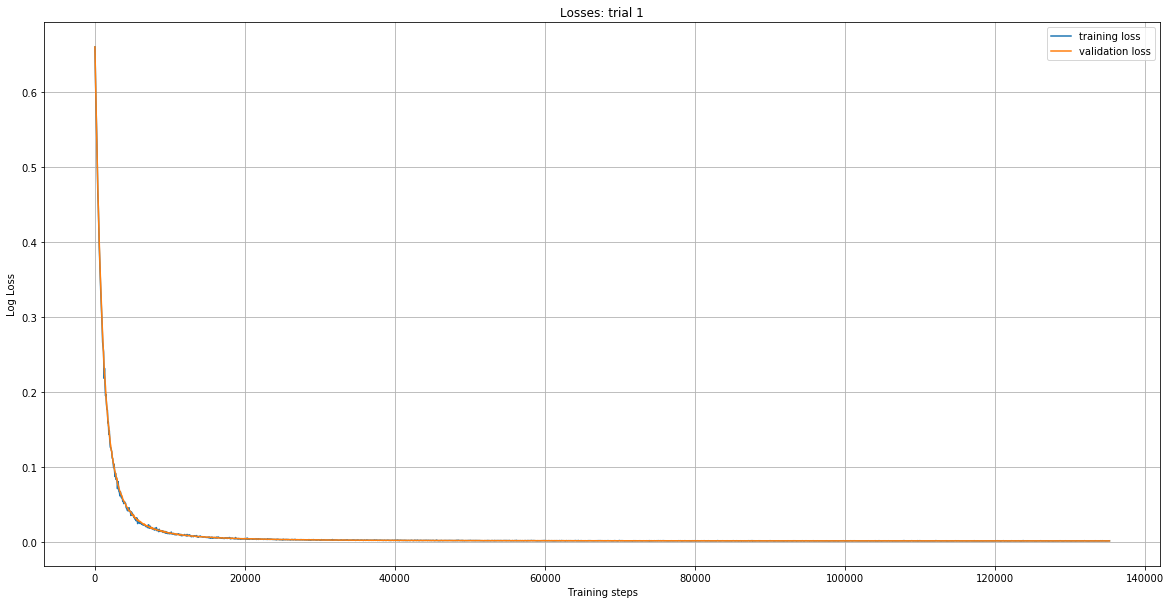

In [74]:
plot_losses(title="Losses: trial 1")
"""
trial 1: took 17 minutes for 1 epoch
Epoch  1, batch 2115, time 16.97m  train loss [0.000973941], valid loss [0.00084493187]; train acc [0.9999193], valid acc [0.99990821]

Had 2 hidden layers

    dense1 = tf.layers.dense(embed, units=512, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')
"""

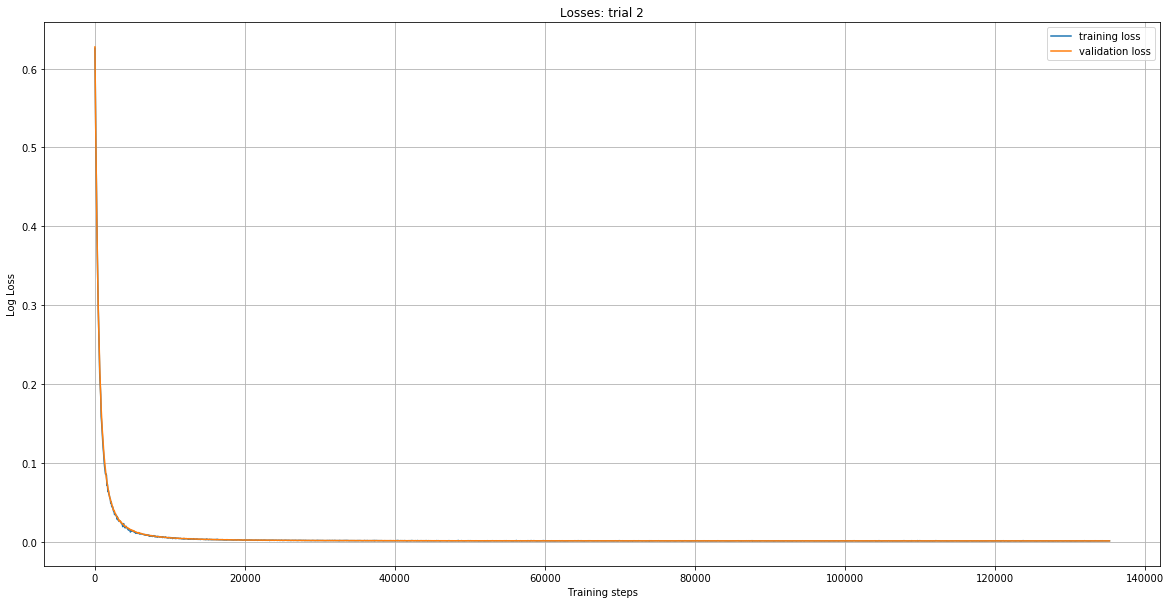

"\ntrial 2: took xx minutes for 1 epoch\nEpoch  1, batch 2115, time 16.97m  train loss [0.000973941], valid loss [0.00084493187]; train acc [0.9999193], valid acc [0.99990821]\n\nHad 1 hidden layer only\n\n    dense1 = tf.layers.dense(embed, units=512, name='fc_dense1')\n    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')\n    relu1 = leaky_relu(bn1,name='fc_relu1')\n    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')\n    \n"

In [136]:
plot_losses(title="Losses: trial 2")
"""
trial 2: took 18.2 minutes for 1 epoch
Epoch  1, batch 2115, time 18.21m  train loss [0.00088472158], valid loss [0.00080440607]; train acc [0.99991935], valid acc [0.99990821]

Had 1 hidden layer only

    dense1 = tf.layers.dense(embed, units=512, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
"""

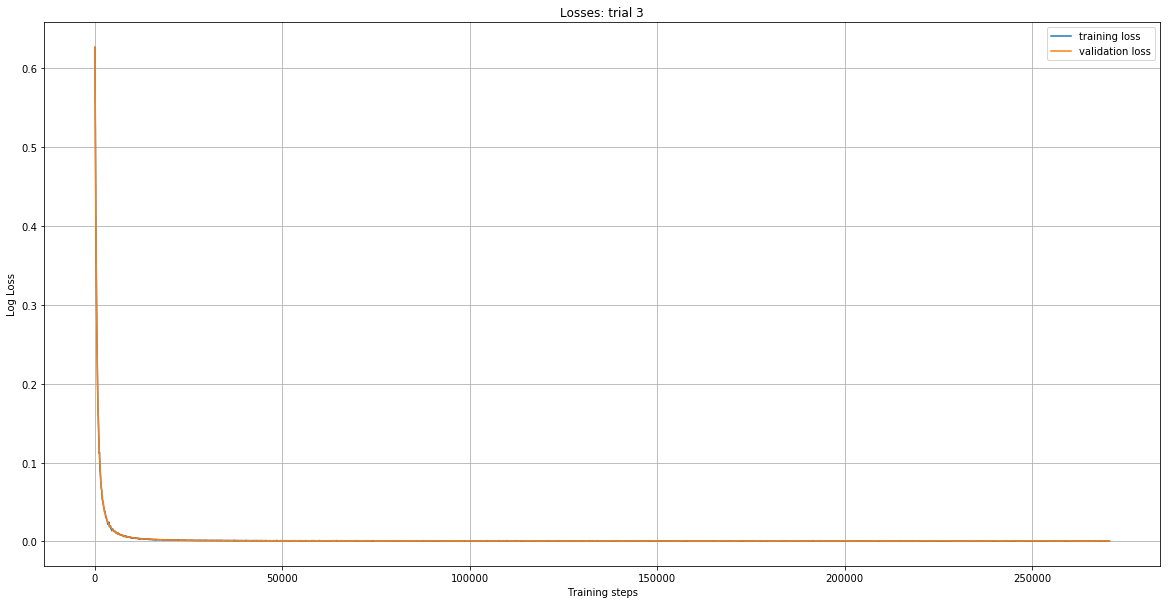

"\ntrial 3: took x minutes for 1 epoch\nEpoch  2, batch 2115, time 36.29m  train loss [0.00080248737], valid loss [0.00080862199]; train acc [0.99991918], valid acc [0.99990833]\n\n2 epochs instead of 1\nHad 1 hidden layer only\n\n    dense1 = tf.layers.dense(embed, units=512, name='fc_dense1')\n    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')\n    relu1 = leaky_relu(bn1,name='fc_relu1')\n    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')\n    \n"

In [143]:

"""
trial 3: took x minutes for 1 epoch
Epoch  2, batch 2115, time 36.29m  train loss [0.00080248737], valid loss [0.00080862199]; train acc [0.99991918], valid acc [0.99990833]

2 epochs instead of 1
Had 1 hidden layer only

    dense1 = tf.layers.dense(embed, units=512, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
"""
plot_losses(title="Losses: trial 3")

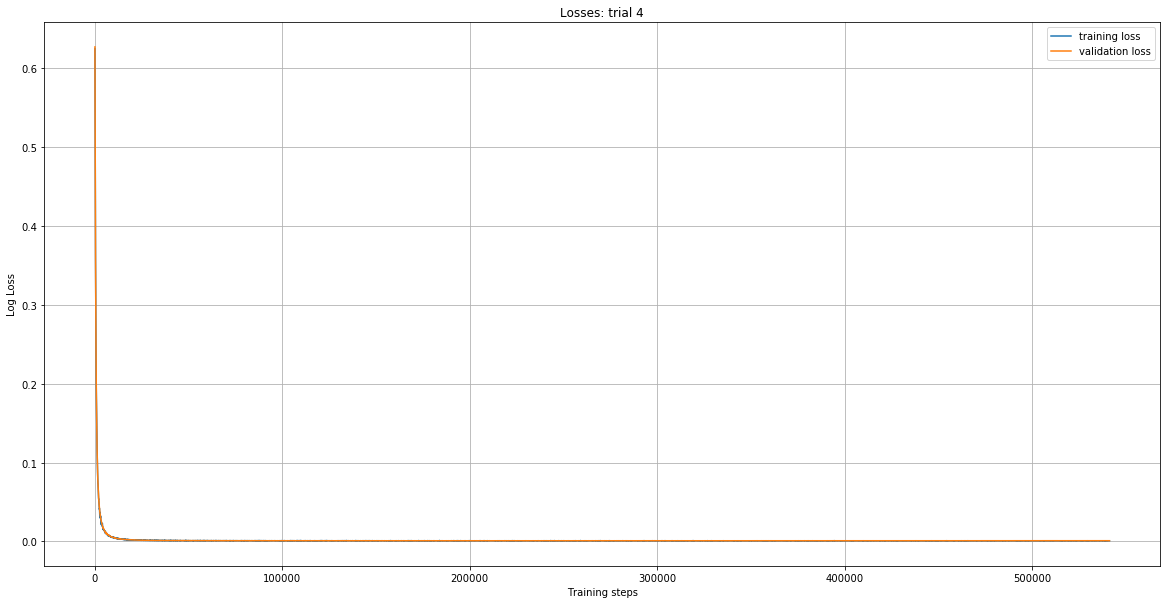

In [42]:

"""
trial 4: took 73 minutes for 1 epoch
Epoch  4, batch 2115, time 72.88m  train loss [0.00063097937], valid loss [0.00086066965]; train acc [0.99992031], valid acc [0.99990815]

train from checkpoint: 6 epochs total
Epoch  6, batch 2115, time 36.69m  train loss [0.00050653511], valid loss [0.0009241933]; train acc [0.99992639], valid acc [0.99990374]

train from checkpoint: 8 epochs total
Epoch  8, batch 2115, time 37.11m  train loss [0.00035289], valid loss [0.00098491693]; train acc [0.99993473], valid acc [0.99990034]

4 epochs instead of 2
Had 1 hidden layer only

    dense1 = tf.layers.dense(embed, units=512, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
"""
plot_losses(title="Losses: trial 4")

## Prediction on test sample

In [76]:
save_model_path = './saved_session'

loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
    
    # Get Tensors from loaded model
    loaded_input_ = loaded_graph.get_tensor_by_name('input:0')
    loaded_target_ = loaded_graph.get_tensor_by_name('target:0')
    loaded_keep_prob_ = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_is_training_ = loaded_graph.get_tensor_by_name('is_training:0')
    loaded_output = loaded_graph.get_tensor_by_name('output:0')
    loaded_loss = loaded_graph.get_tensor_by_name('loss:0')
    loaded_accuracy = loaded_graph.get_tensor_by_name('accuracy:0')

    test_feed = {
        loaded_input_ : x_test,
        loaded_target_ : y_test_hot,
        loaded_keep_prob_ : 1.,
        loaded_is_training_ : False
    }
    
    test_loss, test_accuracy, test_output = sess.run([loaded_loss, loaded_accuracy, loaded_output], feed_dict=test_feed)
    
    print("test_loss: ", test_loss, " test_accuracy: ", test_accuracy)

INFO:tensorflow:Restoring parameters from ./saved_session
test_loss:  0.000877013  test_accuracy:  0.999907


In [30]:
def get_pred(search_l=['excited'], n_suggest=10, search_to_int=search_to_int, int_to_search=int_to_search, epoch=3):
    """
    
    """
    
    search_try = []
    x_test = []
    for s in search_l:
        if s in search_to_int:
            search_try.append(s)
            x_test.append(search_to_int[s])

    x_test = np.array(x_test, ndmin=1)
    
    save_model_path = './saved_session'

    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + "_epoch_{0:02d}".format(epoch) + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_input_ = loaded_graph.get_tensor_by_name('input:0')
        loaded_target_ = loaded_graph.get_tensor_by_name('target:0')
        loaded_keep_prob_ = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_is_training_ = loaded_graph.get_tensor_by_name('is_training:0')
        loaded_output = loaded_graph.get_tensor_by_name('output:0')
        loaded_loss = loaded_graph.get_tensor_by_name('loss:0')
        loaded_accuracy = loaded_graph.get_tensor_by_name('accuracy:0')
        
        
        test_feed = {
            loaded_input_ : x_test,
            loaded_keep_prob_ : 1.,
            loaded_is_training_ : False
        }

        out_l = sess.run(loaded_output, feed_dict=test_feed)
        pred_l = []
        for o in out_l:
            pred = one_hot_to_word(o, n_suggest=10)
            pred_l.append(pred)
        
        
        return search_try, pred_l

In [34]:
def one_hot_to_word(one_hot, n_suggest=10):
    idx_l = np.argpartition(one_hot, -n_suggest)[-n_suggest:]
    pred = []
    for i in range(len(idx_l)):
        pred.append(int_to_search[idx_l[i]])
            
    return pred

In [56]:
search_l = ['excited', 'i love you', 'yes', 'what ever', 'face palm', 'obama', 'party', 'blink', 'wink', 'puppy', 'kitten', 'cute', 'funny']
last_epoch=5
search_try, pred_l = get_pred(search_l=search_l, n_suggest=10, search_to_int=search_to_int, int_to_search=int_to_search, epoch=last_epoch)

INFO:tensorflow:Restoring parameters from ./saved_session


INFO:tensorflow:Restoring parameters from ./saved_session


In [37]:
def print_search_suggestions(search_try, pred_l,title=""):
    print(title)
    for i, search in enumerate(search_try):
        print("search term: {} || suggestions: {}\n".format(search, ', '.join(pred_l[i])))

In [128]:

"""
for trial 1
"""
for i, search in enumerate(search_try):
    print("search term: {} || suggestions: {}\n".format(search, ', '.join(pred_l[i])))
    

search term: excited || suggestions: bye, miss you, kisses, love, cool, goodnight, cuddle, sex, love you, yes

search term: i love you || suggestions: dick, youre amazing, love you more, no, cuddle, love you, love you so much, love, miss you, love you too

search term: yes || suggestions: yes, fart, hours later, pooping, shocked, bye, sad, spongebob, funny, love you

search term: what ever || suggestions: fuck, hey, bye, i miss you, cuddle, love you, youre amazing, happy, love, lol

search term: face palm || suggestions: sleepy, love, sex, two hours later, no, one hour later, spongebob, love you, cuddle, hours later

search term: obama || suggestions: love you so much, dance, kisses, love, no, funny, dick, spongebob, cuddle, love you

search term: party || suggestions: sex, love you too, love, love you more, spongebob, bye, hey, love you, cuddle, love you so much

search term: blink || suggestions: years later, kiss, shocked, funny, fuck, miss you, no, hey, south park, spongebob

searc

In [140]:
"""
trial 2
"""
print_search_suggestions(search_try, pred_l,title="Trial 2, 1 hidden layer")

Trial 2, 1 hidden layer
search term: excited || suggestions: fart, later, breast, one hour later, funny, happy, laughing, no, spongebob, sex

search term: i love you || suggestions: funny, i love you too, cuddle, love you so much, miss you, bye, love, tired, i miss you, love you

search term: yes || suggestions: fight, you love me, i miss you, let me love you, cuddle, love, love you too, fuck, love you, poop

search term: what ever || suggestions: cuddle, horny, excited, bye, i miss you, love, fuck, cool, love you, south park

search term: face palm || suggestions: waiting, i miss you, kisses, okay, omg, oh, shocked, love you, no, spongebob

search term: obama || suggestions: attention, later, love you, kisses, love, fuck you, hey, love you too, cuddle, spongebob

search term: party || suggestions: horny, basketball wives, cuddle, oh, funny, spongebob, hey, sex, cool, miss you

search term: blink || suggestions: fuck, miss you, dick, spongebob, funny, no, you, i miss you, love you, sex

In [144]:
"""
trial 3
"""
print_search_suggestions(search_try, pred_l,title="Trial 3, 1 hidden layer, 2 epochs")

Trial 3, 1 hidden layer, 2 epochs
search term: excited || suggestions: fart, later, breast, one hour later, funny, happy, laughing, no, spongebob, sex

search term: i love you || suggestions: funny, i love you too, cuddle, love you so much, miss you, bye, love, tired, i miss you, love you

search term: yes || suggestions: fight, you love me, i miss you, let me love you, cuddle, love, love you too, fuck, love you, poop

search term: what ever || suggestions: cuddle, horny, excited, bye, i miss you, love, fuck, cool, love you, south park

search term: face palm || suggestions: waiting, i miss you, kisses, okay, omg, oh, shocked, love you, no, spongebob

search term: obama || suggestions: attention, later, love you, kisses, love, fuck you, hey, love you too, cuddle, spongebob

search term: party || suggestions: horny, basketball wives, cuddle, oh, funny, spongebob, hey, sex, cool, miss you

search term: blink || suggestions: fuck, miss you, dick, spongebob, funny, no, you, i miss you, lov

In [39]:
"""
trial 4
"""
print_search_suggestions(search_try, pred_l,title="Trial 4, 1 hidden layer, 2 epochs")

Trial 4, 1 hidden layer, 2 epochs
search term: excited || suggestions: hsppy dance, happy, freakin excited, jessie im so excited, spacehamster, snl excited, excited, so freakin excited, jumpibg excited, so excited snl

search term: i love you || suggestions: kisses, love you more, miss, cute baby, i need you, cuddle, love you, i miss you, i love you too, i love you

search term: yes || suggestions: no, food, absolutely, saved, yay, snoop, sex, excited, yes, gettin it

search term: what ever || suggestions: vine, i will not be silenced, decisions, steve harvey, you'll never know, disney, tutu, whatevee, i will win, you never know

search term: face palm || suggestions: catholic school, delivery, mr chow, fuck yall, nursing, school, nursing school, fuck yiu, rubbing hands, no school

search term: obama || suggestions: super, seinfeld, sunnies, obama pizza, fuck you, cleveland, fuckers, yes sorry, banana hammock, paper

search term: party || suggestions: excited, wayne's world, party, swa

In [57]:
"""
trial 4b
"""
search_l = ['excited', 'i love you', 'yes', 'what ever', 'face palm', 'obama', 'party', 'blink', 'wink', 'puppy', 'kitten', 'cute', 'funny']
last_epoch=5
search_try, pred_l = get_pred(search_l=search_l, n_suggest=10, search_to_int=search_to_int, int_to_search=int_to_search, epoch=last_epoch)
print_search_suggestions(search_try, pred_l,title="Trial 4b, 1 hidden layer, 6 epochs")

Trial 4b, 1 hidden layer, 4 epochs
search term: excited || suggestions: dick, hsppy dance, happy, celebration, lady and the tramp, jumproping, happy  dance, sex, excited, @rtype

search term: i love you || suggestions: i need you, you aint bout that life, miss, i miss you, i choose you, love you, come here, i miss you too, i love you, miss you already

search term: yes || suggestions: jersey shore, zoolander, comedy gold, absolutely, head nod, good job, yes, looking, yeah buddy, excited

search term: what ever || suggestions: caps lock, noises, shouting, noisey, stop yelling at me, whatevee, why are we yelling, noise, be loud, why are you yelling

search term: face palm || suggestions: i know, give it to me, give me a kiss, why, friday, fart, disney, i failed you, pooping, fuck me

search term: obama || suggestions: hey slut, youre lying, stop lyong, you aint gotta lie, lies, your lying, lie, you aint got to lie, that's a lie, sluts

search term: party || suggestions: birthday girl, pa

In [59]:
"""
trial 4c
"""
search_l = ['excited', 'i love you', 'yes', 'what ever', 'face palm', 'party', 'blink', 'wink', 'puppy', 'kitten', 'cute', 'funny', 'obama', 'trump', 'taylor swift','beyonce']
last_epoch=7
search_try, pred_l = get_pred(search_l=search_l, n_suggest=10, search_to_int=search_to_int, int_to_search=int_to_search, epoch=last_epoch)
print_search_suggestions(search_try, pred_l,title="Trial 4b, 1 hidden layer, 8 epochs")

INFO:tensorflow:Restoring parameters from ./saved_session
Trial 4b, 1 hidden layer, 8 epochs
search term: excited || suggestions: yas, tgif, yes, yummy, vacation, yay, dan, excited, wonder woman, metal

search term: i love you || suggestions: i miss you more, miss ypu, babys, i missed you, miss, love you, thinking of you, i miss you too, i need you, i miss you

search term: yes || suggestions: of course, oh yeah, tehehe, jerking off, godamn right, ok, yes, excited, yea, for sure

search term: what ever || suggestions: thats more like it, yes masta, thinking, yes sjr, bye, yes sit, you never know, whatevee, class, delicious

search term: face palm || suggestions: hands, crazy, ouch, fairly odd parents, whining, delivery, michael jordan, rubbing, food delivery, prey

search term: party || suggestions: miss congeniality kiss me, protozoa, swag, miss congenialitt, birthday girl, girls weekend, birthday, miss congeniality, zenon, birthday party

search term: blink || suggestions: shocked wh